# Convolutional Neural Networks
In this notebook, we will get familiar with convolutional neural networks (CNNs) - an important neural network structure for image analysis.

**Learning Objectives**

1. Describe the convolution calculation and how it is applied to images.
2. Outline the components of a convolutional neural network.
3. Implement a convolutional neural network in PyTorch.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from PIL import Image

In [2]:
# modules from PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Let's prepare our device to use PyTorch

In [3]:
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: '+device_name)
device = torch.device(device_name)

Using device: mps


## Motivation
As beings with a visual cortex, images comprise a great deal of the information we receive and how we interact with the world. As a result, much of the data we use is stored as images.

As data, images are stored as two- or three-dimensional arrays with coherent spatial information. For example, consider the following image of a yellow sea sponge:

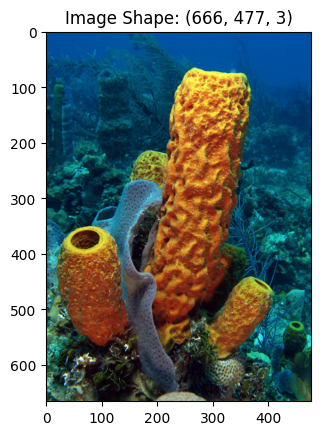

In [4]:
# read in the image of a sponge here
image = Image.open('yellow_sponge.png').convert('RGB')
image_array = np.array(image)
plt.imshow(image)
plt.title('Image Shape: '+str(np.shape(image_array)))
plt.show()

As we can see in the above example, the image is a three-dimensional array with the dimensions corresponding to the shape of the image and the thre "color bands" red, blue, and green. These bands are combined to produce the colors our human eyes can interepret. 

This image is relatively small - just 666x477x3 pixels (in comparison to the 1000's of pixels in, say, modern cell phone camera images). But consider using one of the previous neural network architectures to examine a set of images like this to learn some desirable features. The previous architectures we looked at take in a one-dimensional vector. We might consider "unraveling" the images into a long one-dimensional vector as we did before, but this has two downsides:

1. This image would require 953,046 weights in *each* layer, which would be an incredibly expensive model to train and run.
2. More importantly, by "unraveling" the images, we lose all of the spatial information in the image. In other words, the neighboring points in an image are typically closely related and provide some information about each other.

In short, this approach would not only make our model very expensive, it would also remove valuable information from its construction. To solve this problem, we'll need a relatively cheap two-dimensional operation that can be used to learn about the features in an image - it turns out that a *convolution* is just the thing we need.

## Convolution

A **convolution** is a mathematical operation that involves an input matrix and a convolutional kernel. A convolution can be defined for vectors of any dimension but since the focus here is on CNNs that use 2-dimensional convolutions, the following examples will be shown in 2d. 

Consider a matrix $A$ of size (3,3) and a convolutional kernel $K$ of size (3,3). The convolution of A with K is denoted as

$$
A * K (i,j) = \sum_{i=1}^3 \sum_{j=1}^3 a_{i,j} K_{i,j}
$$

When $A$ is a larger matrix, the convolution is achieved by "sliding" the kernel $K$ over the rows and columns of $A$.

This process can be visualized in the following diagram:


<img src="Convolution_Schematic.png" alt="Schematic of a 2D convolution" width="500">

As we can see in the above image, the value of $A * K$ on row 1 and column 1 is the dot product of values of A in the upper-left 3x3 region of A with the values in the kernel K. This convolution processes is then repeated by "sliding" the kernel across all of the rows and columns of $A$ to fill in the rest of the $A*K$ matrix.

### A Concrete 2D Convolution Example: The Sobel filter

Convolutions have many uses for image processing and different kernels comprised of different organizations of weights have different purposes. Take, for example, the Sobel gradient filter - a simple edge detection filter. The Sobel filter works in two pieces - a gradient in the horizonal direction and a gradient in the vertical direction. Then the result of these two gradients is used to compute a magnitude, which can be thought of as the "sharpness" of the edge.

The kernels for the horizonal and vertical gradients are as follows:

$$
K_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} \,\,\, \text{ and } K_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
$$
These can be thought of as centered-difference approximation to the derivative in the $x$ and $y$ directions.

Let's see how convolution with these kernels works on an example matrix:

In [5]:
# make the gradients
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

In [6]:
# make a test matrix
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [7]:
# compute the convolution using scipy
scipy.signal.convolve2d(A, Kx, mode='valid')

array([[-8]])

We get this result because

$$
\begin{align*}
A * K_x & = (-1)1 + (0)2 + (1)3 + (-2)4 + (0)5 + (2)6 + (-1)7 + (0)8 + (1)9 \\
&= -1 + 0 + 3 - 8 + 0 + 12 - 7 + 0 + 9 \\
&= 8
\end{align*}
$$

Hmm, but wait - what about the minus sign? This arises because the "convolution" in machine learning is actually a cross-correlation. The calculations are identical, but the difference is that the kernel is "flipped" in a convolution while it is not flipped in a cross-correlation. Check this out:

In [8]:
# compute the correlation using scipy
scipy.signal.correlate(A, Kx, mode='valid')

array([[8]])

Let's see how convolution works by applying this filter to an example image of the CNN news network logo:

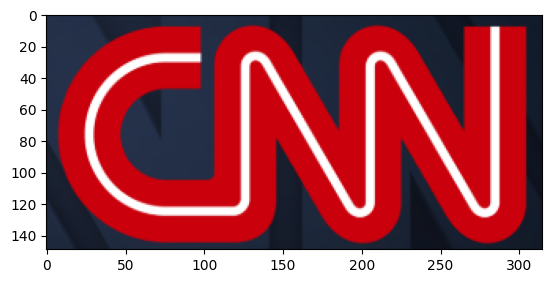

In [9]:
# read in the CNN image here:
image = Image.open('CNN.png')
image_array = np.array(image)
plt.imshow(image)
plt.show()

We can use these kernels across the image to compute the edges. Let's first convert this image to grey scale to keep things a little more clear:

In [10]:
image=image.convert('L')
image_array = np.array(image)

Next, we can compute the convolution:

In [11]:
# make empty arrays for the convolution
Gx = np.zeros_like(image_array)
Gy = np.zeros_like(image_array)

# loop through the rows and columns of the image to
# compute the convolution of the image and the kernel
for row in range(1,np.shape(Gx)[0]-1):
    for col in range(1,np.shape(Gy)[1]-1):
        # gradient in the x direction:
        Gx[row,col] = scipy.signal.convolve2d(image_array[row-1:row+2, col-1:col+2],
                                              Kx, mode='valid')[0][0]
        # gradient in y direction:
        Gy[row,col] = scipy.signal.convolve2d(image_array[row-1:row+2, col-1:col+2],
                                              Ky, mode='valid')[0][0]
        

Let's make a quick plot and see what our gradients look like:

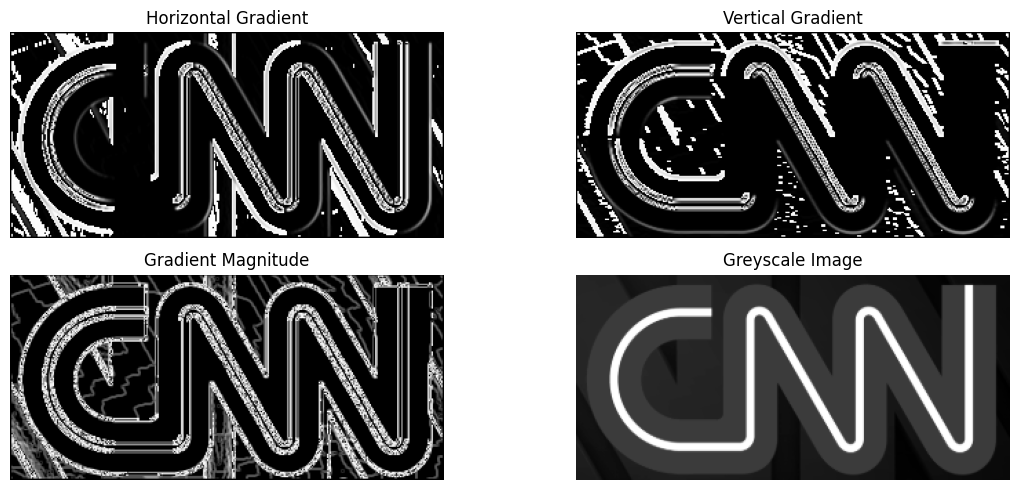

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.imshow(Gx, cmap='Greys_r')
plt.title('Horizontal Gradient')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(Gy, cmap='Greys_r')
plt.title('Vertical Gradient')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow((Gx**2 + Gy**2)**0.5, cmap='Greys_r')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(image_array, cmap='Greys_r')
plt.title('Greyscale Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Our First CNN

Now that we're familiar with the idea of a convolution, let's see how we can leverage this operation for image classification.

### A Peek at the Data
In this example, we will use a set of images for sea creatures that have been classified into five categories - one for each creature. The data are stored into a directory called "Images" with subdirectories for training, testing, and validation. Within each subdirectory, there are additional subdirectories for each of the five classifications [0-4]. Each image has a width and height of 100 pixels each, and there are three "channels" in the image for the red, green, and blue colors that constitute the image.

Let's take a look at the first image of each species in the training data:

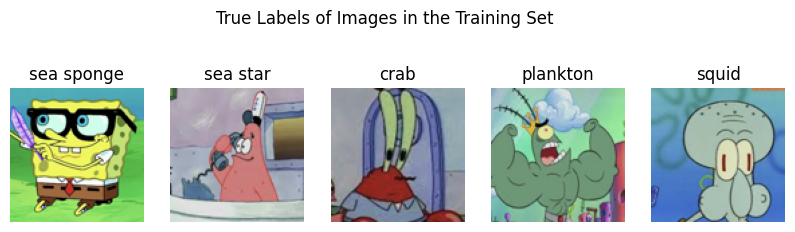

In [13]:
# define the species for each category
species = ['sea sponge', 'sea star', 'crab', 'plankton', 'squid']

# make a figure object
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,5)

# plot the first image for each of the species from the training dataset
for s in range(len(species)):
    
    # load image
    image_list = os.listdir(os.path.join('Images', 'train', str(s)))
    image = Image.open(os.path.join('Images', 'train', str(s), image_list[0])).convert('RGB')

    # plot the image on an axis
    ax = fig.add_subplot(gs[0, s])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(species[s])

plt.suptitle('True Labels of Images in the Training Set')
plt.show()

## Define the CNN Architecture

In this example, we will begin with a relatively simple CNN architecture - one that has two convolutional layers, each with an activation function and a pooling layer, and two additional fully-connected layers. Visually, we can represent this arctitecture graphically as follows:

<img src="CNN_Architecture.png" alt="Schematic of a CNN Architecture" width="800">

In this example, the first two convolutional layers are used to extract pertinent features in the images that may pertain to each species of sea creature. For example, sea sponges may be define by straight edges or corners while sea stars may be defined by triangular features. The pooling layers allow us to example patterns in the images at different scales. Finally, the fully connected layers provide a mechanism to classify the images based on the prominent patterns for each species. When examining this network, it's important to be able to identify what is being trained so we'll state this expicitly: **in a CNN, weights in both the convolutional kernels and the linear layers are optimized via back propagation and gradient descent**.

Using PyTorch, we can construct a class for this CNN as follows:

In [14]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        # construct the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),     # output 16, 100, 100
            nn.ReLU(),                                      # activation function
            nn.MaxPool2d(2),                                # output 16, 50, 50
            nn.Conv2d(16, 32, kernel_size=3, padding=1),    # output 32, 50, 50
            nn.ReLU(),                                      # activation function
            nn.MaxPool2d(2)                                 # output 32, 25, 25
        )
        
        # construct the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                   # output 32 * 25 * 5 = 20000
            nn.Linear(20000, 128),                          # output 128   
            nn.ReLU(),                                      # activation function
            nn.Linear(128, 5)                               # output 5 (number of classes)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### New Layers
In the class above, we see three different layers we haven't encountered in previous networks

- `nn.Conv2d(3, 16, kernel_size=3, padding=1)` - this layer implements the 2D convolutional layer, In this case, we implement a set of 16 3x3x3 kernels. Since each kernel is applied to the input image, the number of channels will increase from 3 to 16 in the subsequent step of the network. 
- `nn.ReLU()` - ReLU is short for "Rectified Linear Unit" and is another activation function similar to the sigmoid activation function we've seen previously. The ReLU activation function returns 0 for negative value and is the identify function for positive values. This is a common choice for neural networks with many layer.
- `nn.MaxPool2d(2)` - max pooling layer chooses the most prominent features in a given area of a pixel. In this case, the maximum value from each 2x2 layer is passed to the next layer and the dimensions of the image will reduce by half.

## Using the Model

Now that we've defined the model, we can use it to classify images. For example, we could use the model to test the first image in the validation dataset for each species:

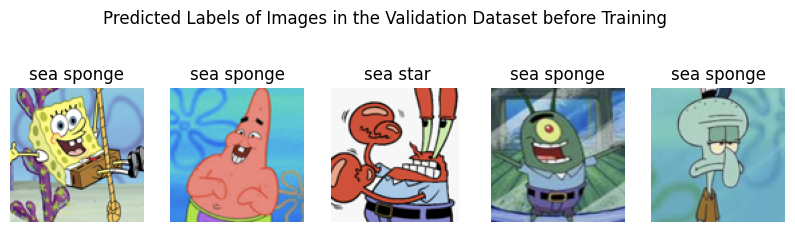

In [17]:
# define the model
model = ClassificationCNN().to(device)

# put the model in evaluation mode
model.eval()

# make a figure object
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,5)

# plot the classifications of the first image for each of the species from the testing dataset
for s in range(len(species)):
    
    # load image
    image_list = os.listdir(os.path.join('Images','validate',str(s)))
    image = Image.open(os.path.join('Images','validate',str(s),image_list[0])).convert('RGB')

    # get the prediction of the species
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    predicted_species = species[predicted.item()]

    # plot the image on an axis
    ax = fig.add_subplot(gs[0, s])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(predicted_species)

plt.suptitle('Predicted Labels of Images in the Validation Dataset before Training')
plt.show()

As we can see, the model isn't doing well - and that's to be expected since we haven't done any training to optimize the weights in the convolutional kernels or the fully connected layers. Let's go ahead and do that now.

## Run a Training Loop

In addition to the architecture of the CNN itself, we also need to identify how we will pre-process the images before feeding them into the network. Here, we will transform the images to PyTorch tensors, and then normalize the data:

In [16]:
# construct a transform for the input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

To run a training loop, we will leverage a few tools to load in the training and testing data:

In [18]:
# define the training and testing mechanisms to load in images as datasets
BATCH_SIZE = 10

# first contruct the training set
train_dataset = datasets.ImageFolder(os.path.join('Images', 'train'), transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# then the testing set
test_dataset = datasets.ImageFolder(os.path.join('Images', 'test'), transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Next, let's define the loss function and the gradient descent function. Since this is a classification example, we will use the Cross Entropy Loss function:

In [19]:
# cross entropy loss for use in classification problems
criterion = nn.CrossEntropyLoss()

We are nearly ready to run our training loop but first, let's bundle up a function to compute the number of correct labels in a set of output so that we can report stats in our training example:

In [20]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i]==0:
            correct +=1
        total += 1
    return(correct, total)

Finally, we are ready to run our training loop. In the following loop, 

In [21]:
# redefine the model here in case cells are run out of order
# for instructional purposes
model = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
# note that this uses the given model object's parameters
# and therefore must be defined after the model is defined 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 20

# make empty lists to keep track of the training and testing losses
train_losses = []
test_losses = []

# loop through each epoch to run the training loop
# and check the model with the training data
# keep track of both sets of losses as you go
for epoch in range(NUM_EPOCHS):
    
    # Run the training loop (put model in training mode)
    model.train()

    total_train_loss = 0.0
    total_train_correct = 0
    total_train_images = 0
    
    for train_inputs, train_labels in train_loader:
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        # implement the forward method
        optimizer.zero_grad()
        outputs = model(train_inputs)

        # compute stats
        train_correct, train_total = compute_correct_labels(outputs, train_labels)
        total_train_correct += train_correct
        total_train_images += train_total

        # implement the loss and the backward method
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # compute stats
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Run the testing loop (put model in eval mode)
    model.eval()
    
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_images = 0
    
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            # implement the forward method
            outputs = model(test_inputs)

            # compute stats
            test_correct, test_total = compute_correct_labels(outputs, test_labels)
            total_test_correct += test_correct
            total_test_images += test_total
            loss = criterion(outputs, test_labels)
            total_test_loss += loss.item()
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
          f" - Train Loss: {avg_train_loss:.4f}, "+\
          f"Train Correct: {total_train_correct}/{total_train_images} "+\
          f"- Test Loss: {avg_test_loss:.4f}, "+\
          f"Test Correct: {total_test_correct}/{total_test_images} ")

Epoch 1/20 - Train Loss: 1.6993, Train Correct: 44/175 - Test Loss: 1.5797, Test Correct: 16/50 
Epoch 2/20 - Train Loss: 1.3592, Train Correct: 88/175 - Test Loss: 1.4282, Test Correct: 26/50 
Epoch 3/20 - Train Loss: 0.8360, Train Correct: 125/175 - Test Loss: 1.3244, Test Correct: 31/50 
Epoch 4/20 - Train Loss: 0.3557, Train Correct: 158/175 - Test Loss: 1.0546, Test Correct: 32/50 
Epoch 5/20 - Train Loss: 0.1674, Train Correct: 165/175 - Test Loss: 0.8594, Test Correct: 35/50 
Epoch 6/20 - Train Loss: 0.1415, Train Correct: 167/175 - Test Loss: 0.9612, Test Correct: 33/50 
Epoch 7/20 - Train Loss: 0.0390, Train Correct: 173/175 - Test Loss: 0.7871, Test Correct: 38/50 
Epoch 8/20 - Train Loss: 0.0102, Train Correct: 175/175 - Test Loss: 0.8421, Test Correct: 38/50 
Epoch 9/20 - Train Loss: 0.0048, Train Correct: 175/175 - Test Loss: 0.8882, Test Correct: 36/50 
Epoch 10/20 - Train Loss: 0.0033, Train Correct: 175/175 - Test Loss: 0.9299, Test Correct: 37/50 
Epoch 11/20 - Train L

## Visualize the Training and Testing Losses
Now that we've run our training loop, let's have a peek at our training and testing losses. This should give us a sense for how well our model is doing and what issues might be hiding in our design:

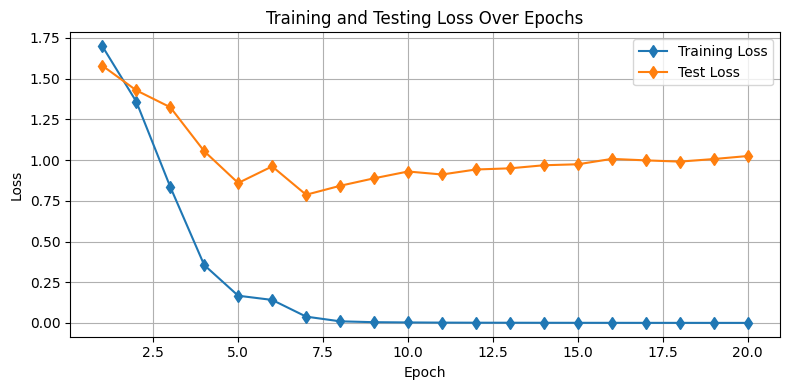

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Questions for Consideration

1. How is the model performing on the training data?
2. How is the model performing on the testing data?
3. To what extent might this model be underfit or overfit?

## Test the Model on the Validation Set

We can see in the plot above that there are likely some issues in our model. Don't worry - we will fix that in the next notebook. For now, let's see how our model is doing on each of the images in our validation set.

First, define an image loader just like we did for our training and testing data:

In [23]:
# define the validation data loader
validation_dataset = datasets.ImageFolder(root=os.path.join('Images','validate'), transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=5, shuffle=False)

Next, let's apply the model to each of our 5 validation images for each of the 5 species:

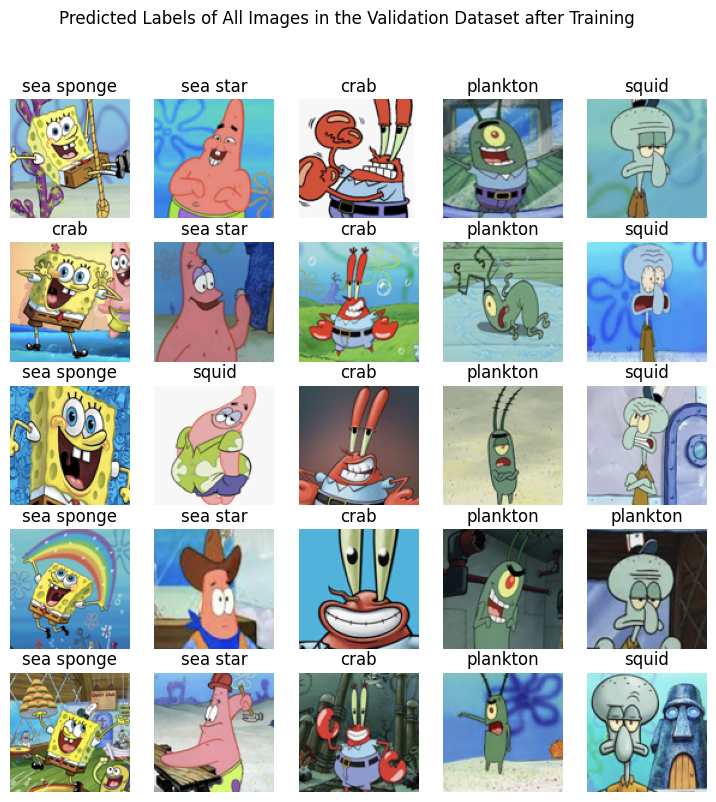

In [24]:
# Set model to evaluation mode
model.eval()

# make a figure object
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(5, len(species))

# loop through each species (column)
for s in range(len(species)):

    # loop through the image files
    file_list = os.listdir(os.path.join('Images','validate',str(s)))[:5]
    for file_count, file_name in enumerate(file_list):

        # load the image
        image = Image.open(os.path.join('Images','validate',str(s),file_name)).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # get the predicted class
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = species[predicted.item()]

        # add the image to the plot with the prediction
        ax = fig.add_subplot(gs[file_count, s])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(predicted_class)
        file_count +=1

plt.suptitle('Predicted Labels of All Images in the Validation Dataset after Training')
plt.show()

Our model is working pretty well on the validation set! However, there's still lots of room for improvement here. Let's see what our options are in the next notebook.